# Table of Contents
---
1. Prelimiary Code
2. Aggregate numbers and questions
3. Explanatory Data Analysis
   * Airports
      * Flights departure per airports + there corresponding delays
      * Flights arrivals per airports + there corresponding delays
      * Map of flights departures
      * Map of flights departures delays
   * Time - Series
      * Daily
      * Monthly
      * Yearly
   * Seasonality
      * Weekday
      * Months
   * Airlines
      * Fresh Airline (new in market)
   * By State - Time-Series
      * Yearly - delays + flights
4. Summary of EDA
5. ML - `Departure_delays` prediction
   * Regression Type
      * Rigde
      * Lasso
      * XGBoost
   * Classification Type - **To Do**
      * Logistic Regression
      * LDA?
      * AdaBoost      

# 1.Prelimiary Code
---

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.reset_orig() # don't change the style of plots

import glob
import datetime
import matplotlib.dates as mdates

from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from mpl_toolkits.basemap import Basemap

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
cwd = os.getcwd()
os.chdir(r"C:\Users\heyde\Documents\02 - Job Applications\DataTonic Challenge\inputs")
cwd = os.getcwd()

csv_files = glob.glob('*.csv')
csv_files

['flights_large.csv', 'flights_medium.csv', 'weather.csv']

# 2. Aggregate numbers and Questions
---

In [5]:
flights_df = pd.read_csv(csv_files[0])
weather_df = pd.read_csv(csv_files[2])

In [6]:
flights_df.head(2)

,Date,Airline,Airline_code,Arrival_airport,Arrival_state,Departure_Airport,Departure_State,Departure_actual,Departure_delay,Arrival_actual,Arrival_delay,Arrival_schedule,Departure_schedule,DC_Longitude,DC_Latitude,Longitude,Latitude,Route,Path_order
0,2010-12-27,HA,19690,SAN,CA,HNL,HI,1311,1,2047,12,2035.0,1310.0,-157.92,21.31,-157.92,21.31,HI to CA,1
1,2004-04-10,HA,19690,SAN,CA,HNL,HI,1336,11,2146,11,2135.0,1325.0,-157.92,21.31,-157.92,21.31,HI to CA,1


In [7]:
flights_df['Date'] = pd.to_datetime(flights_df['Date'])

In [8]:
#flights_df.nunique()

In [9]:
print("Time Period: 2003 - 2013")
print("Number of flights:", len(flights_df))
print("Number of airlines: 23")
print("Number of Departure Airports: 234")
print("Number of Arrival Airports: 67")

Time Period: 2003 - 2013
Number of flights: 10000000
Number of airlines: 23
Number of Departure Airports: 234
Number of Arrival Airports: 67


**Notes**:
* 234 departure Airports but only 67 Arrival airports.
* 23 airlines in our data


**Questions raised - concerns:**
* difference between `DC_Longitude` and `Longitude`
* difference between `DC_Latitude` and `Latitude`
* Path-order?

In [10]:
flights_df[flights_df.DC_Longitude != flights_df.Longitude].tail(2)

,Date,Airline,Airline_code,Arrival_airport,Arrival_state,Departure_Airport,Departure_State,Departure_actual,Departure_delay,Arrival_actual,Arrival_delay,Arrival_schedule,Departure_schedule,DC_Longitude,DC_Latitude,Longitude,Latitude,Route,Path_order
9894840,2010-04-24,WN,19393,TUL,OK,DAL,TX,1421,16,1512,7,1505.0,1405.0,-96.85,32.84,-95.88,36.19,TX to OK,2
9894841,2003-10-03,WN,19393,TUL,OK,DAL,TX,1730,0,1825,0,1825.0,1730.0,-96.85,32.84,-95.88,36.19,TX to OK,2


# 3. EDA - Explanatory Data Analysis
---

_To measure the trend of delays within time, we need to take it in account it with the trend of number of flights._  

## 3.1 Airports
---

In [11]:
## Largest Airports

# By Departure
DepAirport_df = pd.DataFrame(flights_df['Departure_Airport'].value_counts())
DepAirport_df.columns = ['Number_of_departures']
# By Arrival
AriAirport_df = pd.DataFrame(flights_df['Arrival_airport'].value_counts())
AriAirport_df.columns = ['Number_of_arrivals']

# These values should be very-close. As if a plane lands it needs to take off. 
# However, we are keeping this seperate, as we have only 67 different Airports, where planes have arrived, 
# compared to 234 different Departure ones. 

In [12]:
DepAirport_df.head()

,Number_of_departures
ATL,755903
ORD,600014
DFW,588351
IAH,344271
SEA,271121


In [13]:
AriAirport_df.head()

,Number_of_arrivals
PHX,1214197
DEN,1050768
CLT,1041075
CVG,858405
PHL,747867


### Notes:
---
It looks like some Information is missing in our data, because we have a big disporportion of the number of flights arriving at an airport and flights departuring from the same airport.  This should be roughly the same as when a plane lands it also needs to take off #=> arrivals and departures should be the same for the airports, but they aren't.  


So, we should remember that we have such a bias in the data, or maybe we are missing something from the data --> maybe `Path_order` stands for some of the return flights? or maybe some of the airports changed codes.

In [14]:
#flights with departure delays
flights_depdelays_df = flights_df[flights_df['Departure_delay'] > 0]
#flights with arrival delays
flights_aridelays_df = flights_df[flights_df['Arrival_delay'] > 0]

In [15]:
## airports with highest departure delays
flights_depdelays_airport_df = flights_depdelays_df.groupby("Departure_Airport")\
    .agg({'Departure_delay' : ['count', np.mean]}).sort_values([('Departure_delay', 'count')], ascending = False)
    
flights_depdelays_airport_df.reset_index(inplace = True)
flights_depdelays_airport_df.columns = ['Airport', 'Number_of_delays', 'Mean_of_delays']
    
## airports with highest arrival delays
flights_aridelays_airport_df = flights_aridelays_df.groupby('Arrival_airport')\
    .agg({'Arrival_delay' : ['count', np.mean]}).sort_values([('Arrival_delay', 'count')], ascending = False)
    
flights_aridelays_airport_df.reset_index(inplace = True)
flights_aridelays_airport_df.columns = ['Airport', 'Number_of_delays', 'Mean_of_delays']

In [16]:
## Merged with the number of flights departure
flight_dep_airport_df = pd.merge(flights_depdelays_airport_df, DepAirport_df, left_on = "Airport", right_index = True)\
    .sort_values('Number_of_departures', ascending = False).set_index("Airport")
    
## Get the proportion of flights delayed to all flights    
flight_dep_airport_df['Proportion'] = round(flight_dep_airport_df['Number_of_delays']\
    .divide(flight_dep_airport_df['Number_of_departures']) * 100,2)  

DF_map = flight_dep_airport_df.copy()

## Apply Percentage formatting
flight_dep_airport_df['Proportion'] = pd.Series(["{0:.2f}%".format(val) for val in flight_dep_airport_df['Proportion']],\
                                                index = flight_dep_airport_df.index)

## Merged with the number of flights arrival
flight_ari_airport_df = pd.merge(flights_aridelays_airport_df, AriAirport_df, left_on = "Airport", right_index = True)\
    .sort_values('Number_of_arrivals', ascending = False).set_index("Airport")
    
## Get the proportion of flights delayed to all flights    
flight_ari_airport_df['Proportion'] = round(flight_ari_airport_df['Number_of_delays']\
    .divide(flight_ari_airport_df['Number_of_arrivals']) * 100,2)
 
## Apply percentage formatting
flight_ari_airport_df['Proportion'] = pd.Series(["{0:.2f}%".format(val) for val in flight_ari_airport_df['Proportion']],\
                                                index = flight_ari_airport_df.index)

In [17]:
print("Departure Delays:")
flight_dep_airport_df.head(5)

Departure Delays:


,Number_of_delays,Mean_of_delays,Number_of_departures,Proportion
Airport,,,,
ATL,329920,29.967674,755903,43.65%
ORD,253079,34.208891,600014,42.18%
DFW,232299,28.078188,588351,39.48%
IAH,134515,24.600855,344271,39.07%
SEA,108467,25.108300,271121,40.01%


In [18]:
print("Arrival Delays:")
flight_ari_airport_df.head(5)

Arrival Delays:


,Number_of_delays,Mean_of_delays,Number_of_arrivals,Proportion
Airport,,,,
PHX,464234,23.094588,1214197,38.23%
DEN,412388,27.111955,1050768,39.25%
CLT,427806,24.607820,1041075,41.09%
CVG,328261,26.700068,858405,38.24%
PHL,322134,34.385349,747867,43.07%


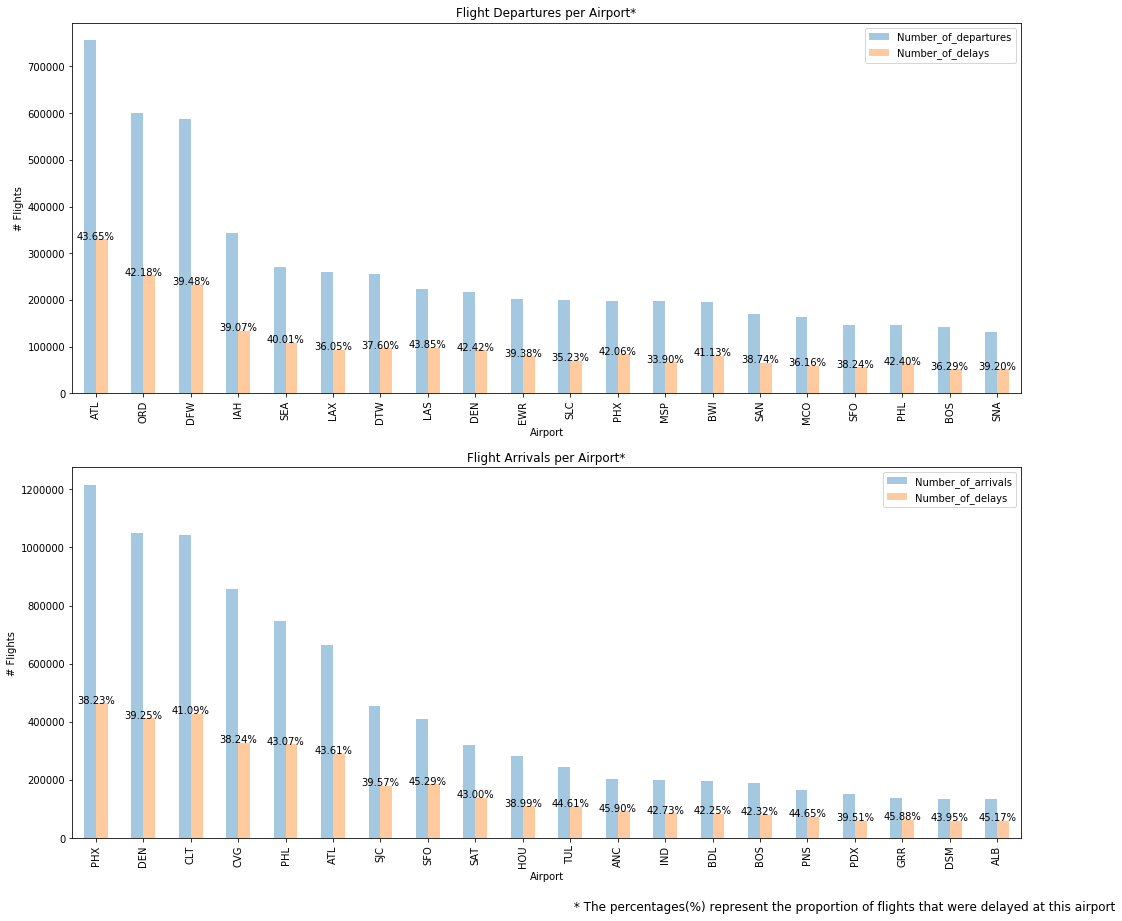

In [19]:
fig, axes = plt.subplots(figsize=(17, 15), nrows = 2, ncols =1)

font = {'weight': 'normal', 'size': 12}

#Plot 1
flight_dep_airport_df[['Number_of_departures', 'Number_of_delays']][:20].plot.bar(alpha=0.4, ax=axes[0])
    
for i, child in enumerate(axes[0].get_children()[20:40]):
    axes[0].text(i, child.get_bbox().y1, flight_dep_airport_df.sort_values(by = ['Number_of_departures'], ascending = False)\
                 .Proportion[i], horizontalalignment ='center')

#Plot2    
flight_ari_airport_df[['Number_of_arrivals', 'Number_of_delays']][:20].plot.bar(alpha=0.4, ax=axes[1])

for i, child in enumerate(axes[1].get_children()[20:40]):
    axes[1].text(i, child.get_bbox().y1, flight_ari_airport_df.sort_values(by = ['Number_of_arrivals'], ascending = False)\
                 .Proportion[i], horizontalalignment ='center')

    #row and    
axes[0].set_title('Flight Departures per Airport*')
axes[0].set_ylabel("# Flights");
axes[1].set_title('Flight Arrivals per Airport*')
axes[1].set_ylabel("# Flights");
axes[1].text(10, -250000, r' * The percentages(%) represent the proportion of flights that were delayed at this airport', fontdict=font);

In [20]:
Departure_Airports_df = flights_df[['Departure_Airport', 'DC_Longitude', 'DC_Latitude']].drop_duplicates().sort_values('Departure_Airport')
Departure_Airports_df.reset_index(drop = True, inplace = True)

count_flights = flights_df['Departure_Airport'].value_counts()

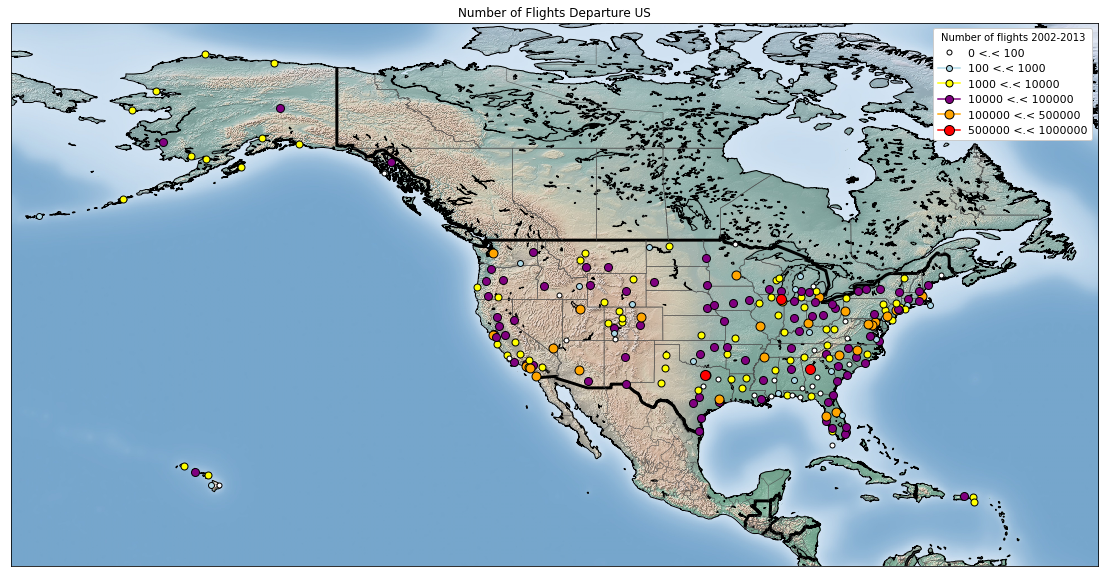

In [21]:
colors = ['white','lightblue', 'yellow', 'purple', 'orange', 'red', 'black']
size_limits = [0, 100, 1000, 10000, 100000, 500000, 1000000]

labels = []
for i in range(len(size_limits)-1):
    labels.append("{} <.< {}".format(size_limits[i], size_limits[i+1]))
    
#-----------------------------------------------
plt.figure(figsize=(20,10))

map = Basemap(resolution='i',llcrnrlon=-180, urcrnrlon=-50,
              llcrnrlat=10, urcrnrlat=75, lat_0=0, lon_0=0,)
map.shadedrelief()
map.drawcoastlines()
map.drawcountries(linewidth = 3)
map.drawstates(color='0.3')

#_____________________
# put airports on map
for index, (code, y,x) in Departure_Airports_df[['Departure_Airport', 'DC_Latitude', 'DC_Longitude']].iterrows():
    x, y = map(x, y)
    isize = [i for i, val in enumerate(size_limits) if val < count_flights[code]]
    ind = isize[-1]
    map.plot(x, y, marker='o', markersize = ind+5, markeredgewidth = 1, color = colors[ind],
             markeredgecolor='k', label = labels[ind])
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
key_order = ('0 <.< 100', '100 <.< 1000', '1000 <.< 10000',
             '10000 <.< 100000','100000 <.< 500000', '500000 <.< 1000000')
new_label = OrderedDict()

plt.title("Number of Flights Departure US")
for key in key_order:
    new_label[key] = by_label[key]
plt.legend(new_label.values(), new_label.keys(), loc = 1, prop= {'size':11},
           title='Number of flights 2002-2013', frameon = True, framealpha = 1);

In [22]:
DF = pd.merge(Departure_Airports_df, pd.DataFrame(DF_map['Proportion']), left_on =  "Departure_Airport",\
        right_index = True).reset_index(drop = True)

count_flights2 = DF[['Departure_Airport', 'Proportion']].set_index('Departure_Airport')
count_flights2 = count_flights2['Proportion']
count_flights2 = count_flights2.sort_values()

DF = DF[~DF.Departure_Airport.isin(count_flights2[count_flights2 == 100].index.tolist())]

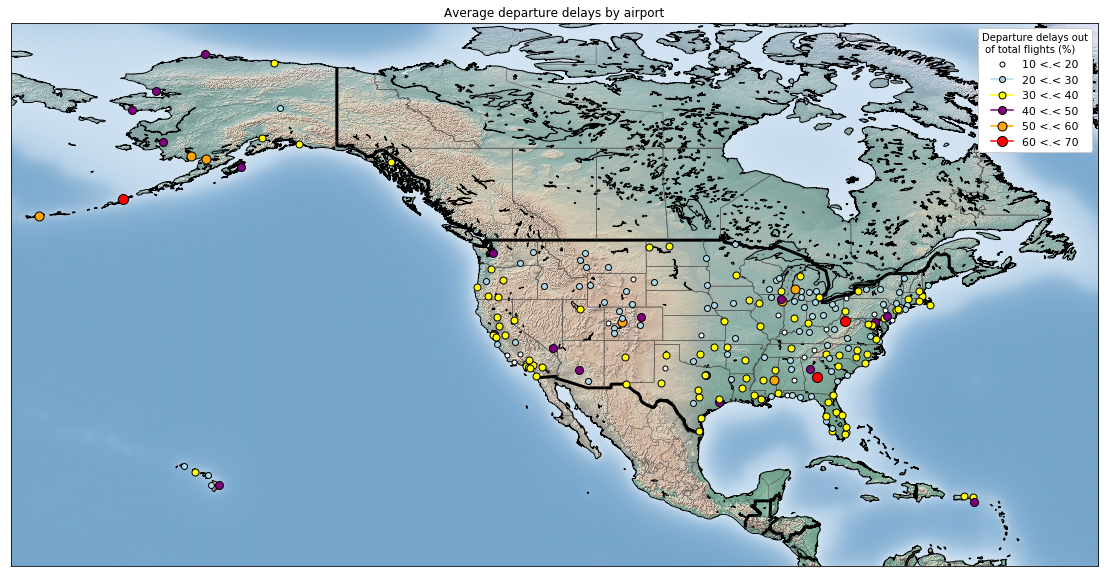

In [23]:
colors = ['white','lightblue', 'yellow', 'purple', 'orange', 'red', 'black']
size_limits = [10, 20, 30, 40, 50, 60, 70]

labels = []
for i in range(len(size_limits)-1):
    labels.append("{} <.< {}".format(size_limits[i], size_limits[i+1]))
    
#-----------------------------------------------
plt.figure(figsize=(20,10))

map = Basemap(resolution='i',llcrnrlon=-180, urcrnrlon=-50,
              llcrnrlat=10, urcrnrlat=75, lat_0=0, lon_0=0,)
map.shadedrelief()
map.drawcoastlines()
map.drawcountries(linewidth = 3)
map.drawstates(color='0.3')

#_____________________
# put airports on map
for index, (code, y,x) in DF[['Departure_Airport', 'DC_Latitude', 'DC_Longitude']].iterrows():
    x, y = map(x, y)
    isize = [i for i, val in enumerate(size_limits) if val <= count_flights2[code]]
    ind = isize[-1]
    map.plot(x, y, marker='o', markersize = ind+5, markeredgewidth = 1, color = colors[ind],
             markeredgecolor='k', label = labels[ind])
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
key_order = ('10 <.< 20', '20 <.< 30', '30 <.< 40',
             '40 <.< 50','50 <.< 60','60 <.< 70')
new_label = OrderedDict()

plt.title("Average departure delays by airport")
for key in key_order:
    new_label[key] = by_label[key]
plt.legend(new_label.values(), new_label.keys(), loc = 1, prop= {'size':11},
           title='Departure delays out\n of total flights (%)', frameon = True, framealpha = 1);

In [24]:
## I have tried a similiar plot for the arrival delays, and flights but we have much less airports in the data
# and the plot becomes useless

## 3.2 Time-Series  
---
### 3.2.1 Daily
---

In [25]:
## No of Flights
flights_TimeSeries_df = pd.DataFrame({"Number_of_flights" : flights_df['Date'].value_counts().sort_index()})
flights_TimeSeries_df['Departure_delays'] = flights_depdelays_df['Date'].value_counts()
flights_TimeSeries_df['Arrival_delays'] = flights_aridelays_df['Date'].value_counts()

flights_TimeSeries_df['Dep_delays_proportion'] = round(flights_TimeSeries_df['Departure_delays']\
    .divide(flights_TimeSeries_df["Number_of_flights"])*100,1)

flights_TimeSeries_df['Ari_delays_proportion'] = round(flights_TimeSeries_df['Arrival_delays']\
    .divide(flights_TimeSeries_df["Number_of_flights"])*100,1)    

In [26]:
flights_TimeSeries_df.head(2)

,Number_of_flights,Departure_delays,Arrival_delays,Dep_delays_proportion,Ari_delays_proportion
2002-01-01,1977,866,831,43.8,42.0
2002-01-02,1986,1185,1176,59.7,59.2


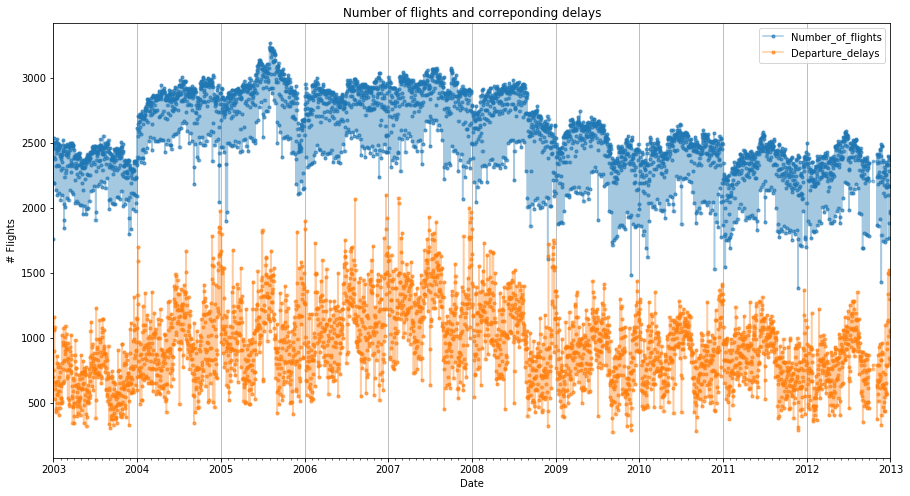

In [27]:
days = mdates.DayLocator()
months = mdates.MonthLocator()
years = mdates.YearLocator()

fig, ax = plt.subplots(figsize=(15, 8))

ax.step(flights_TimeSeries_df.index, flights_TimeSeries_df['Number_of_flights'],\
             alpha=0.4, marker = '.', where = 'mid')
ax.step(flights_TimeSeries_df.index, flights_TimeSeries_df['Departure_delays'],\
             alpha=0.4, marker = '.', where = 'mid')
#ax.step(flights_TimeSeries_df.index, flights_TimeSeries_df['Arrival_delays'],\
 #            alpha=0.4, marker = '.', where = 'mid')


ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_locator(years)
ax.set_title("Number of flights and correponding delays")
ax.set_xlabel("Date")
ax.set_ylabel("# Flights");

ax.set_xlim([datetime.date(2003, 1, 1), datetime.date(2013, 1, 1)]);
ax.xaxis.set_minor_locator(months)
ax.xaxis.grid(True)
ax.legend();

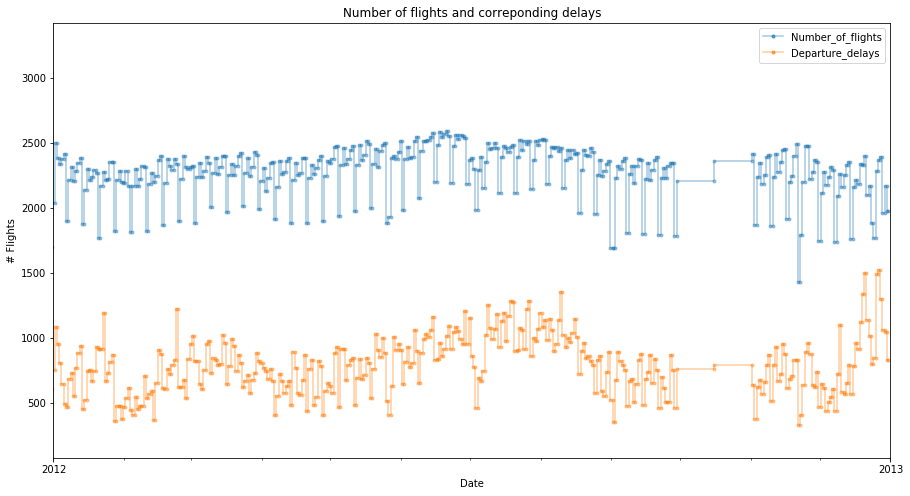

In [28]:
fig, ax = plt.subplots(figsize=(15, 8))

ax.step(flights_TimeSeries_df.index, flights_TimeSeries_df['Number_of_flights'],\
             alpha=0.4, marker = '.', where = 'mid')
ax.step(flights_TimeSeries_df.index, flights_TimeSeries_df['Departure_delays'],\
             alpha=0.4, marker = '.', where = 'mid')

ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_locator(years)
ax.set_title("Number of flights and correponding delays")
ax.set_xlabel("Date")
ax.set_ylabel("# Flights");

ax.set_xlim([datetime.date(2012, 1, 1), datetime.date(2013, 1, 1)]);
ax.xaxis.set_minor_locator(months)
ax.xaxis.grid(True)
ax.legend();

## Observations by now:
---
Time range: 2003 -> 2013

* There seems to be some weekday (weekends lees flights?) seasonality in the data => **Check next -> _weekday analysis_**
* Also check for some seasonality in the months => **Check next -> _Months analysis_**
* Years 2004 to 2009 seem to have more flights than others => **Check next -> _ yearly analysis_**

* The departure and arrival delay counts are really similiar. However the magnitude of Arrival delays at the end is a bit large, meaning that some flights have only arrival delays but no departure delays => the delays is caused while flying.

### 3.2.2 Monthly
---

In [29]:
flights_monthly_TimeSeries_df = \
    flights_TimeSeries_df[['Number_of_flights', 'Departure_delays', 'Arrival_delays']].resample('M').sum().reset_index()

flights_monthly_TimeSeries_df.columns = ["Date",'Number_of_flights', 'Departure_delays', 'Arrival_delays']

flights_monthly_TimeSeries_df['Dep_delay_prop'] = \
    round(flights_monthly_TimeSeries_df['Departure_delays'].divide(flights_monthly_TimeSeries_df['Number_of_flights'])*100,1)
flights_monthly_TimeSeries_df['Ari_delay_prop'] = \
    round(flights_monthly_TimeSeries_df['Arrival_delays'].divide(flights_monthly_TimeSeries_df['Number_of_flights'])*100,1)

In [30]:
flights_monthly_TimeSeries_df.head()

,Date,Number_of_flights,Departure_delays,Arrival_delays,Dep_delay_prop,Ari_delay_prop
0,2002-01-31,62315,22365,26707,35.9,42.9
1,2002-02-28,54337,18213,21675,33.5,39.9
2,2002-03-31,60722,25512,29629,42.0,48.8
3,2002-04-30,60656,20731,26692,34.2,44.0
4,2002-05-31,59846,19514,24017,32.6,40.1


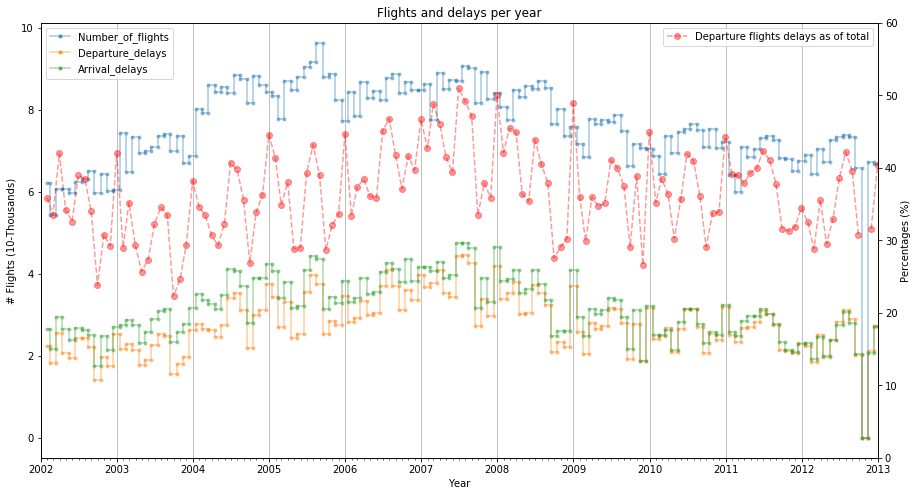

In [31]:
fig, ax = plt.subplots(figsize=(15, 8))

ax.step(flights_monthly_TimeSeries_df['Date'], flights_monthly_TimeSeries_df['Number_of_flights'].divide(10000),\
             alpha=0.4, marker = '.', where = 'mid')
ax.step(flights_monthly_TimeSeries_df['Date'], flights_monthly_TimeSeries_df['Departure_delays'].divide(10000),\
             alpha=0.4, marker = '.', where = 'mid')
ax.step(flights_monthly_TimeSeries_df['Date'], flights_monthly_TimeSeries_df['Arrival_delays'].divide(10000),\
             alpha=0.4, marker = '.', where = 'mid')

ax2 = ax.twinx()
ax2.plot(flights_monthly_TimeSeries_df['Date'], flights_monthly_TimeSeries_df['Dep_delay_prop'],\
             alpha=0.4, marker = 'o',linestyle='--', color='red', label = "Departure flights delays as of total")
#ax2.plot(flights_monthly_TimeSeries_df['Date'], flights_monthly_TimeSeries_df['Ari_delay_prop'],\
 #            alpha=0.4, marker = 'o',linestyle='--', color='yellow', label = "(Proportion of arrival flights delays")

ax2.set_ylim(0,60)
ax2.set_ylabel("Percentages (%)")

ax.set_title("Flights and delays per year")
ax.set_xlabel("Year")
ax.set_ylabel("# Flights (10-Thousands)");
ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_locator(months)
ax.set_xlim([datetime.date(2002, 1, 1), datetime.date(2013, 1, 1)]);
ax.xaxis.grid(True)
ax.legend(loc = 2);
ax2.legend();

### Observations:
---
* **Sudden fall in November 2012** - [Superstorm Sandy](https://www.huffingtonpost.com/2012/10/30/flight-cancellations-superstorm-sandy_n_2044102.html) 21k flights cancelled.
* The proportion of delays seems to have some seasonality within the months **Check next -> Months analysis**


### 3.2.3 Yearly
---

In [32]:
flights_yearly_timeSeries_df = flights_TimeSeries_df[['Number_of_flights', 'Departure_delays', 'Arrival_delays']].resample('Y').sum().reset_index()
flights_yearly_timeSeries_df.columns = ["Date",'Number_of_flights', 'Departure_delays', 'Arrival_delays']
flights_yearly_timeSeries_df['Year'] = flights_yearly_timeSeries_df['Date'].dt.strftime('%Y')
flights_yearly_timeSeries_df.set_index("Year", inplace = True)
flights_yearly_timeSeries_df.drop('Date', axis = 1, inplace = True)

flights_yearly_timeSeries_df['Dep_delay_prop'] = \
    round(flights_yearly_timeSeries_df['Departure_delays'].divide(flights_yearly_timeSeries_df['Number_of_flights'])*100,1)
flights_yearly_timeSeries_df['Ari_delay_prop'] = \
    round(flights_yearly_timeSeries_df['Arrival_delays'].divide(flights_yearly_timeSeries_df['Number_of_flights'])*100,1)

In [33]:
flights_yearly_timeSeries_df.head()

,Number_of_flights,Departure_delays,Arrival_delays,Dep_delay_prop,Ari_delay_prop
Year,,,,,
2002,733686,254235,297764,34.7,40.6
2003,850784,255935,333456,30.1,39.2
2004,1016971,355014,435168,34.9,42.8
2005,1036311,373463,443071,36.0,42.8
2006,1017223,407381,463120,40.0,45.5


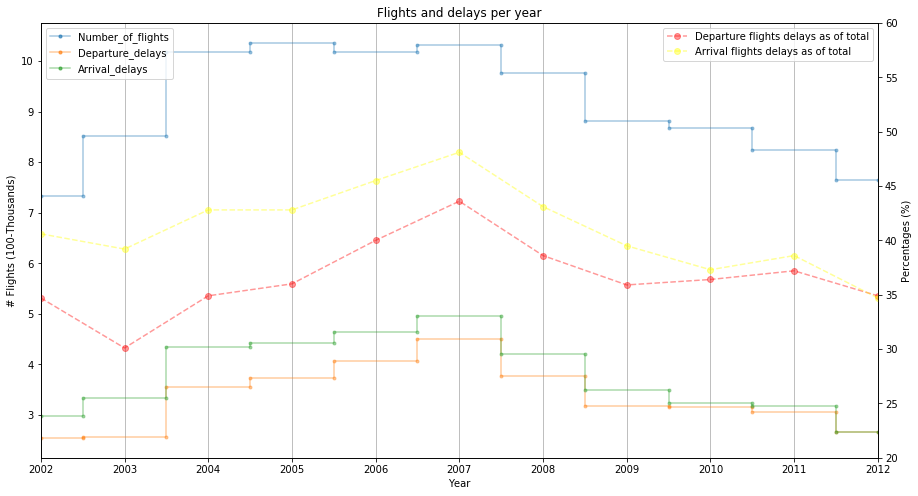

In [34]:
fig, ax = plt.subplots(figsize=(15, 8))

ax.step(flights_yearly_timeSeries_df.index, flights_yearly_timeSeries_df['Number_of_flights'].divide(100000),\
             alpha=0.4, marker = '.', where = 'mid')
ax.step(flights_yearly_timeSeries_df.index, flights_yearly_timeSeries_df['Departure_delays'].divide(100000),\
             alpha=0.4, marker = '.', where = 'mid')
ax.step(flights_yearly_timeSeries_df.index, flights_yearly_timeSeries_df['Arrival_delays'].divide(100000),\
             alpha=0.4, marker = '.', where = 'mid')

ax2 = ax.twinx()
ax2.plot(flights_yearly_timeSeries_df.index, flights_yearly_timeSeries_df['Dep_delay_prop'],\
             alpha=0.4, marker = 'o',linestyle='--', color='red', label = "Departure flights delays as of total")
ax2.plot(flights_yearly_timeSeries_df.index, flights_yearly_timeSeries_df['Ari_delay_prop'],\
             alpha=0.4, marker = 'o',linestyle='--', color='yellow', label = "Arrival flights delays as of total")

ax2.set_ylim(20,60)
ax2.set_ylabel("Percentages (%)")

ax.set_title("Flights and delays per year")
ax.set_xlabel("Year")
ax.set_ylabel("# Flights (100-Thousands)");
ax.set_xlim(2002,2012)
ax.xaxis.grid(True)
ax.legend(loc = 2);
ax2.legend();

## Observations:
---
* More flights in 2004 to 2008
* Delay rate quite stable around 35% - peak in 2007, 2003 lowest, last years in the data seems to decrease
* Seems to be a positive correlation between the number of flights and the percentage of delays.

## 3.3. Seasonality
---

### 3.3.1 Weekday 
---

In [35]:
### define sorter of weekdays
sorter_days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
sorterIndex_days = dict(zip(sorter_days,range(1,len(sorter_days)+1)))

In [36]:
flights_weekday_df = flights_TimeSeries_df[['Number_of_flights', 'Departure_delays', 'Arrival_delays']].reset_index()
flights_weekday_df.columns = ['Date','Number_of_flights', 'Departure_delays', 'Arrival_delays']
flights_weekday_df['Weekday'] = flights_weekday_df['Date'].dt.strftime('%a')
flights_weekday_df['Weekday'] = flights_weekday_df['Weekday'].map(sorterIndex_days)
flights_weekday_df = flights_weekday_df.groupby('Weekday').sum().reset_index()

In [37]:
flights_weekday_df['Dep_delay_prop'] = \
    round(flights_weekday_df['Departure_delays'].divide(flights_weekday_df['Number_of_flights'])*100,1)
flights_weekday_df['Ari_delay_prop'] = \
    round(flights_weekday_df['Arrival_delays'].divide(flights_weekday_df['Number_of_flights'])*100,1)

In [38]:
flights_weekday_df.head()

,Weekday,Number_of_flights,Departure_delays,Arrival_delays,Dep_delay_prop,Ari_delay_prop
0,1,1477104,558011,620672,37.8,42.0
1,2,1451423,484643,574726,33.4,39.6
2,3,1466858,507655,601197,34.6,41.0
3,4,1477098,571464,655993,38.7,44.4
4,5,1483085,597383,667662,40.3,45.0


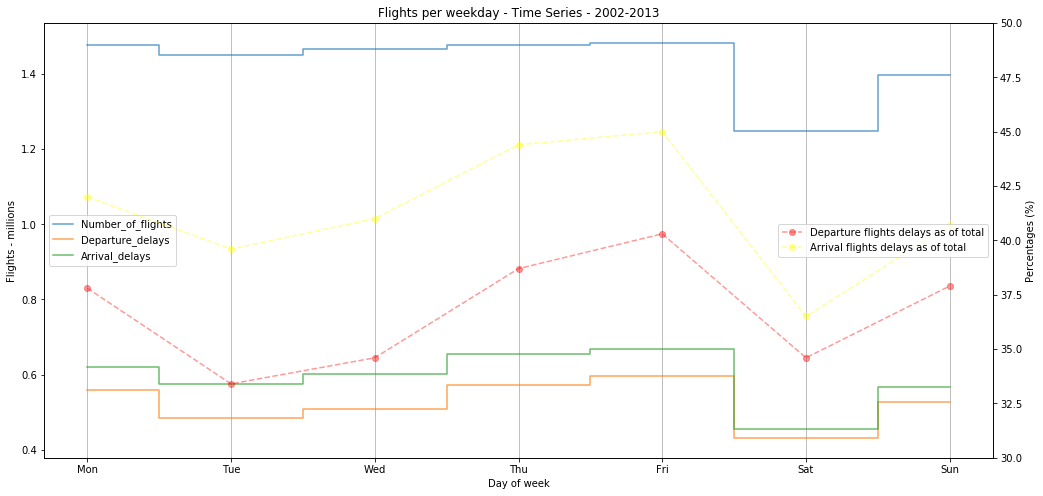

In [39]:
fig, ax = plt.subplots(figsize=(17, 8))

ax.step(flights_weekday_df['Weekday'], flights_weekday_df['Number_of_flights'].divide(1e6), alpha = 0.7, where = 'mid')
ax.step(flights_weekday_df['Weekday'], flights_weekday_df['Departure_delays'].divide(1e6), alpha = 0.7, where = 'mid')
ax.step(flights_weekday_df['Weekday'], flights_weekday_df['Arrival_delays'].divide(1e6), alpha = 0.7, where = 'mid')

ax2 = ax.twinx()
ax2.plot(flights_weekday_df['Weekday'], flights_weekday_df['Dep_delay_prop'],\
             alpha=0.4, marker = 'o',linestyle='--', color='red', label = "Departure flights delays as of total")
ax2.plot(flights_weekday_df['Weekday'], flights_weekday_df['Ari_delay_prop'],\
             alpha=0.4, marker = 'o',linestyle='--', color='yellow', label = "Arrival flights delays as of total")

ax.set_title("Flights per weekday - Time Series - 2002-2013")
ax.set_xlabel("Day of week");
ax.set_ylabel("Flights - millions");
ax.xaxis.grid(True)
ax.set_xticks([1,2,3,4,5,6,7])
ax.set_xticklabels(sorter_days)
ax2.set_ylim(30,50)
ax2.set_ylabel("Percentages (%)")
ax.legend(loc = 6);
ax2.legend(loc = 5);

## Observations:

* less flights during the weekends, especially on Saturdays - business related?
* More delays on Thursdays and Fridays.
* Less delays on Saturdays and Tuesdays.

### 3.3.2 Months
---

In [40]:
### define sorter of Months
sorter_mon = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov' , 'Dec']
sorterIndex_mon = dict(zip(sorter_mon,range(1,len(sorter_mon)+1)))

In [41]:
flights_month_df = flights_TimeSeries_df[['Number_of_flights', 'Departure_delays', 'Arrival_delays']].reset_index()
flights_month_df.columns = ['Date','Number_of_flights', 'Departure_delays', 'Arrival_delays']
flights_month_df['Month'] = flights_month_df['Date'].dt.strftime('%b')
flights_month_df['Month'] = flights_month_df['Month'].map(sorterIndex_mon)
flights_month_df = flights_month_df.groupby('Month').sum().reset_index()

In [42]:
flights_month_df['Dep_delay_prop'] = \
    round(flights_month_df['Departure_delays'].divide(flights_month_df['Number_of_flights'])*100,1)
flights_month_df['Ari_delay_prop'] = \
    round(flights_month_df['Arrival_delays'].divide(flights_month_df['Number_of_flights'])*100,1)

In [43]:
flights_month_df.head()

,Month,Number_of_flights,Departure_delays,Arrival_delays,Dep_delay_prop,Ari_delay_prop
0,1,825640,302877,347404,36.7,42.1
1,2,767321,284479,326247,37.1,42.5
2,3,860880,325962,361638,37.9,42.0
3,4,832722,277816,324085,33.4,38.9
4,5,856874,293181,342059,34.2,39.9


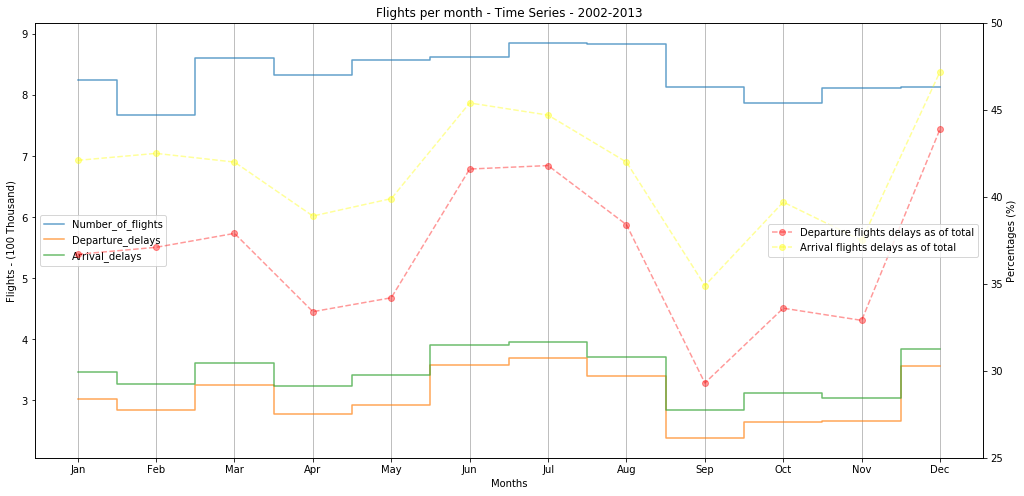

In [44]:
fig, ax = plt.subplots(figsize=(17, 8))

ax.step(flights_month_df['Month'], flights_month_df['Number_of_flights'].divide(1e5), alpha = 0.7, where = 'mid')
ax.step(flights_month_df['Month'], flights_month_df['Departure_delays'].divide(1e5), alpha = 0.7, where = 'mid')
ax.step(flights_month_df['Month'], flights_month_df['Arrival_delays'].divide(1e5), alpha = 0.7, where = 'mid')

ax2 = ax.twinx()
ax2.plot(flights_month_df['Month'], flights_month_df['Dep_delay_prop'],\
             alpha=0.4, marker = 'o',linestyle='--', color='red', label = "Departure flights delays as of total")
ax2.plot(flights_month_df['Month'], flights_month_df['Ari_delay_prop'],\
             alpha=0.4, marker = 'o',linestyle='--', color='yellow', label = "Arrival flights delays as of total")

ax.set_title("Flights per month - Time Series - 2002-2013")
ax.set_xlabel("Months");
ax.set_ylabel("Flights - (100 Thousand)");
ax.xaxis.grid(True)
ax.set_xticks([1,2,3,4,5,6,7,8,9,10,11,12])
ax.set_xticklabels(sorter_mon)
ax2.set_ylim(25,50)
ax2.set_ylabel("Percentages (%)")
ax.legend(loc = 6);
ax2.legend(loc = 5);

### Observations:
---

* Higher delays in December - maybe due to snow/weather
* Higher delays in summer period - maybe because of the small increase over the number of flight during that period.

* Once again there are more Arrival flights delays than Departure ones. #=> meaning some of the flights get delays during fly time. #=> maybe waiting for landing permission etc.

## 3.4. Airlines
---

In [45]:
dates_airline_joined = flights_df[['Date', 'Airline']].groupby('Airline').min().sort_values('Date')
dates_airline_joined['No']= np.ones(len(dates_airline_joined))
dates_airline_joined = dates_airline_joined.groupby('Date').sum()
dates_airline_joined['Cumulative'] = dates_airline_joined['No'].cumsum()

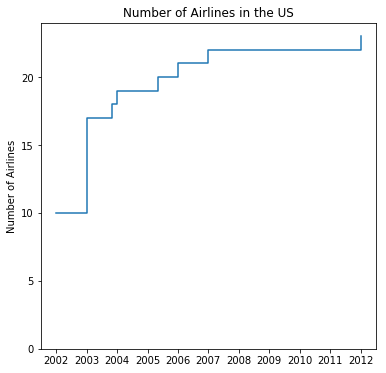

In [46]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.step(dates_airline_joined.index,dates_airline_joined['Cumulative'], where = 'post')
ax.set_ylim(0,24)
ax.set_ylabel("Number of Airlines");
ax.set_title("Number of Airlines in the US");

In [47]:
##to add - delays by airlines...
#flights_depdelays_df

In [48]:
flights_df.head()

,Date,Airline,Airline_code,Arrival_airport,Arrival_state,Departure_Airport,Departure_State,Departure_actual,Departure_delay,Arrival_actual,Arrival_delay,Arrival_schedule,Departure_schedule,DC_Longitude,DC_Latitude,Longitude,Latitude,Route,Path_order
0,2010-12-27,HA,19690,SAN,CA,HNL,HI,1311,1,2047,12,2035.0,1310.0,-157.92,21.31,-157.92,21.31,HI to CA,1
1,2004-04-10,HA,19690,SAN,CA,HNL,HI,1336,11,2146,11,2135.0,1325.0,-157.92,21.31,-157.92,21.31,HI to CA,1
2,2004-04-29,HA,19690,SAN,CA,HNL,HI,1404,39,2223,48,2135.0,1325.0,-157.92,21.31,-157.92,21.31,HI to CA,1
3,2008-09-09,HA,19690,SAN,CA,HNL,HI,1333,-2,2147,-3,2150.0,1335.0,-157.92,21.31,-157.92,21.31,HI to CA,1
4,2011-03-30,HA,19690,SAN,CA,HNL,HI,1314,-1,2158,23,2135.0,1315.0,-157.92,21.31,-157.92,21.31,HI to CA,1


In [49]:
df = flights_df.copy()

In [50]:
delay_type = lambda x:( (0,1)[x > 3],2)[x > 45]
df['DELAY_LEVEL'] = df['Departure_delay'].apply(delay_type)

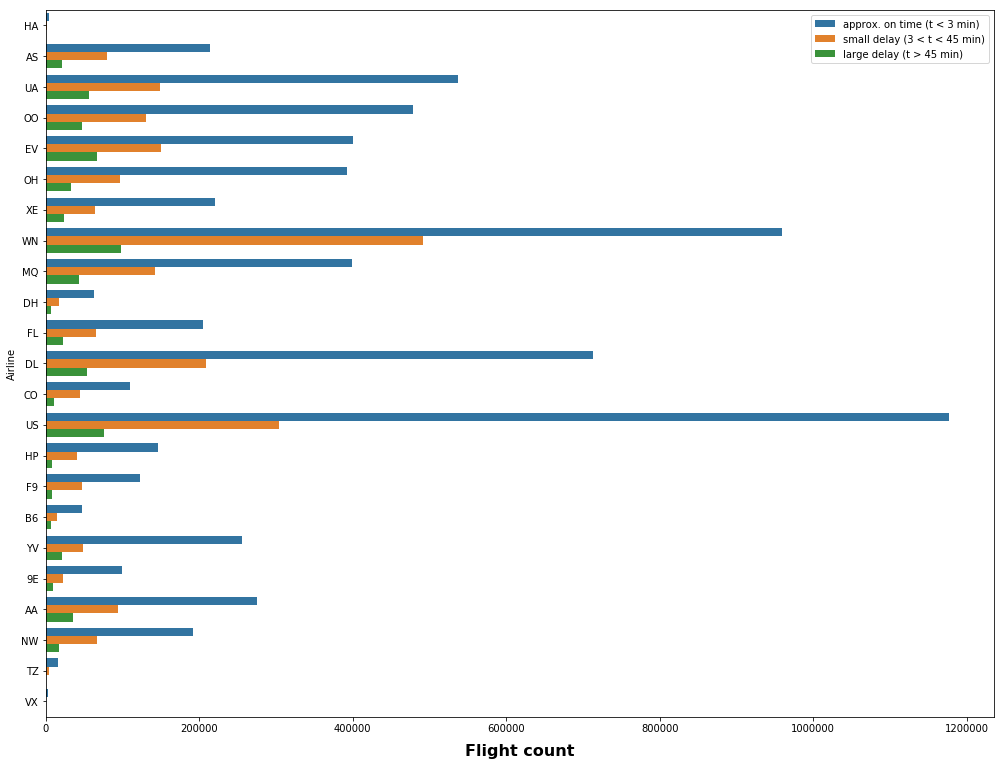

In [51]:
fig = plt.figure(1, figsize=(17,13))
ax = sns.countplot(y="Airline", hue='DELAY_LEVEL', data=df)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)
L = plt.legend()
L.get_texts()[0].set_text('approx. on time (t < 3 min)')
L.get_texts()[1].set_text('small delay (3 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)');

### Observations:
---
* The airlines tend to have the same proportion of small delays and large delays.
* only WN - Country United States seem to have a large porportion of small delays compare to others
* we could mine more information while looking depear into each one.

## 3.5. By State - Time-Series
---

In [52]:
flights_bystate_S = flights_df['Departure_State'].value_counts()
top20states_list = flights_bystate_S[:20].index.tolist()

In [53]:
flights_bystate_monthly_TimeSeries = flights_df.groupby(['Departure_State','Date']).count()['Airline'].unstack('Departure_State')
flights_bystate_monthly_TimeSeries = flights_bystate_monthly_TimeSeries.resample('M').sum() # for monthly change `Y` to `M`
flights_bystate_monthly_TimeSeries = flights_bystate_monthly_TimeSeries.stack('Departure_State').reset_index()
flights_bystate_monthly_TimeSeries.columns = ['Date', 'Departure_state' , 'No_flights']

In [54]:
## Yearly delays and flights for states...
depdelays_bystate_yearly_TimeSeries = flights_depdelays_df.groupby(['Departure_State','Date']).count()['Airline'].reset_index()
depdelays_bystate_yearly_TimeSeries.columns = ['Departure_state', 'Date', 'DepDelays']

flights_bystate_yearly_TimeSeries = flights_df.groupby(['Departure_State','Date']).count()['Airline'].reset_index(['Date', 'Departure_State'])
flights_bystate_yearly_TimeSeries.columns = ['Departure_state' ,'Date', 'No_flights']
flights_bystate_yearly_TimeSeries = pd.merge(flights_bystate_yearly_TimeSeries,depdelays_bystate_yearly_TimeSeries, on = ['Date', 'Departure_state'])

flights_bystate_yearly_TimeSeries = flights_bystate_yearly_TimeSeries.set_index(['Departure_state', 'Date']).unstack('Departure_state')
flights_bystate_yearly_TimeSeries = flights_bystate_yearly_TimeSeries.resample('Y').sum() # for monthly change `Y` to `M`
flights_bystate_yearly_TimeSeries = flights_bystate_yearly_TimeSeries.stack('Departure_state').reset_index()

#Proportion
flights_bystate_yearly_TimeSeries['Dep_delay_prop'] = \
    round(flights_bystate_yearly_TimeSeries['DepDelays'].divide(flights_bystate_yearly_TimeSeries['No_flights'])*100,1)

In [55]:
flights_bystate_yearly_TimeSeries.head()

,Date,Departure_state,No_flights,DepDelays,Dep_delay_prop
0,2002-12-31,AK,11216.0,4469.0,39.8
1,2002-12-31,AL,2511.0,682.0,27.2
2,2002-12-31,AR,1807.0,659.0,36.5
3,2002-12-31,AZ,14196.0,5471.0,38.5
4,2002-12-31,CA,78337.0,27175.0,34.7


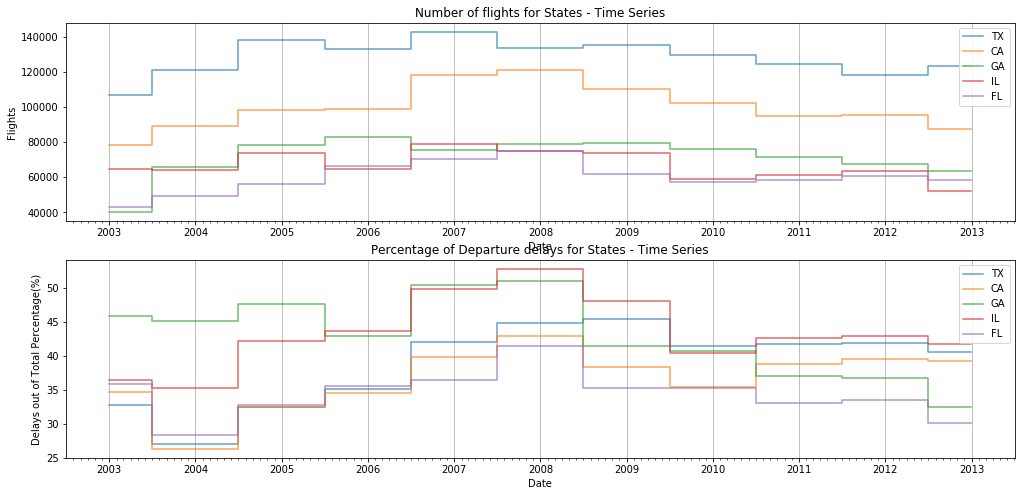

In [56]:
fig, ax = plt.subplots(figsize=(17, 8), nrows = 2, ncols =1)

for state_name in top20states_list[:5]:
    xx = flights_bystate_yearly_TimeSeries[flights_bystate_yearly_TimeSeries['Departure_state'] == state_name]
    ax[0].step(xx['Date'], xx['No_flights'], alpha = 0.7, label = state_name, where = 'mid')

ax[0].set_title("Number of flights for States - Time Series")
ax[0].set_xlabel("Date");
ax[0].set_ylabel("Flights");
ax[0].xaxis.grid(True)
ax[0].xaxis.set_major_locator(years)
ax[0].xaxis.set_minor_locator(months)
ax[0].legend();

for state_name in top20states_list[:5]:
    xx = flights_bystate_yearly_TimeSeries[flights_bystate_yearly_TimeSeries['Departure_state'] == state_name]
    ax[1].step(xx['Date'], xx['Dep_delay_prop'], alpha = 0.7, label = state_name, where = 'mid')

ax[1].set_title("Percentage of Departure delays for States - Time Series")
ax[1].set_xlabel("Date");
ax[1].set_ylabel("Delays out of Total Percentage(%)");
ax[1].xaxis.grid(True)
ax[1].xaxis.set_major_locator(years)
ax[1].xaxis.set_minor_locator(months)
ax[1].legend();

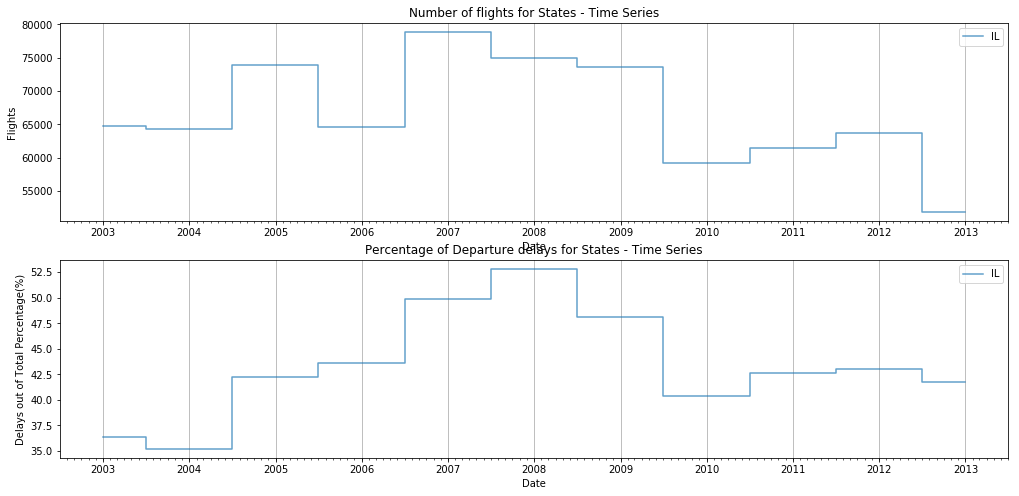

In [57]:
fig, ax = plt.subplots(figsize=(17, 8), nrows = 2, ncols =1)

for state_name in top20states_list[3:4]:
    xx = flights_bystate_yearly_TimeSeries[flights_bystate_yearly_TimeSeries['Departure_state'] == state_name]
    ax[0].step(xx['Date'], xx['No_flights'], alpha = 0.7, label = state_name, where = 'mid')

ax[0].set_title("Number of flights for States - Time Series")
ax[0].set_xlabel("Date");
ax[0].set_ylabel("Flights");
ax[0].xaxis.grid(True)
ax[0].xaxis.set_major_locator(years)
ax[0].xaxis.set_minor_locator(months)
ax[0].legend();

for state_name in top20states_list[3:4]:
    xx = flights_bystate_yearly_TimeSeries[flights_bystate_yearly_TimeSeries['Departure_state'] == state_name]
    ax[1].step(xx['Date'], xx['Dep_delay_prop'], alpha = 0.7, label = state_name, where = 'mid')

ax[1].set_title("Percentage of Departure delays for States - Time Series")
ax[1].set_xlabel("Date");
ax[1].set_ylabel("Delays out of Total Percentage(%)");
ax[1].xaxis.grid(True)
ax[1].xaxis.set_major_locator(years)
ax[1].xaxis.set_minor_locator(months)
ax[1].legend();

### Observations
---

* no clear pattern - one could spend more time mining to extract some interesting information
* for the monthly data - the slump in Nov 2012 is visible - it is 0 - we don't have the information there..
* once again years 2005-2009 have more flights
* states `MI`, `NY` seems to have a decreasing number of flights
* There seems to be a correlation between the number of flights and there corresponding percentage of delays


# 4. Summary of EDA
---

* First we notice that there is a large discreptancy between the number of arrival flights and departure flights for the same airport
  * It seems not natural, as it should be roguhly the same as when plane lands it should take off at the airport
* From the TimeSeries we found out:
  * More arrival flights delays than Departure ones. #=> meaning some of the flights get delays during fly time. #=> maybe waiting for landing permission etc.
  * Years 2004 to 2009 seem to have more flights than others
  * November 2012 - no data, and - [Superstorm Sandy](https://www.huffingtonpost.com/2012/10/30/flight-cancellations-superstorm-sandy_n_2044102.html) 21k flights cancelled.
  * Delay rate quite stable around 35% - peak in 2007, 2003 lowest, last years in the data seems to decrease
  * Seems to be a positive correlation between the number of flights and the percentage of delays.
* From the weekday Seasonality we found out:
  * there are less flights during the weekends, especially on Saturdays - business related?
  * More delays on Thursdays and Fridays.
  * Less delays on Saturdays and Tuesdays.
* From the Months Seasonality we found out:
  * Higher delays in December - maybe due to snow/weather
  * Higher delays in summer period - maybe because of the small increase over the number of flight during that period.
* From the  Airlines Summary:
  * The airlines tend to have the same proportion of small delays and large delays.
  * only WN - Country United States seem to have a large porportion of small delays compare to others
  * we could mine more information while looking depear into each one.



# 5. ML - `Departure_delay` prediction
---


**ASSUMPTIONS:**
* As our data for departures look more reliable we will focus on that part! Prediction on `Departure_delay`
* We want to keep the model fairly simple, but a one that has enough predict power
* We want to predict future delays so the information is "ex-ante". So:
  * We treat the `weather` information as a forecast for the upcoming date - 
     * _note_ this forecast is 100% right, but that is not always the case.
  * We don't have the information about the `arrival_delays`, as so the `Arrival_actual` - skip that features
  * The `route`,  has collinearity with the `Arrival_state`, `Departure_State` - contains less information so we skip that.
  * The `Arrival_state`, `Departure_State` has collinearity with `Departure_Airport` and `Arrival_airport` - skip these features
  * The `DC_Longitude`,	`DC_Latitude`,`Longitude`, `Latitude` has collinearity with `Departure_Airport` - skip these features
  * The `Airline_code` is the same as `Airline` - skip that feature
  
**So we are left with:**  
**Flights.csv:**
* `Depature_delay` - our dependent variable/prediction
* `Date` #=> transfrom into seasonality components - `Months`, `Weekdays`, `Years`
* `Airline`
* `Arrival_airport`
* `Departure_Airport`
* `Departure_schedule` 
* `Arrival_schedule` - should play a susbstantial role, but maybe the some flights are delays because there is overcrowding on the arrival airport - that varies of time.
* `Path_order` - I am not sure what that variable describes - maybe it is the first or return flight of the airplane.

**Weather.csv:**
* `temparature`
* `snow`
* `wind`


**Time Range:**
* as our weather.csv data is till 2007-07-18 we will take a subset of the data from `2005-01-01 till 2007-07-18`
* will try to predict the departure delays for the flight during the 18day period i.e from `2007-07-01 till 2007-07-18`
* as mentioned before we treat the weather as a forecast.

  
  
  



In [5]:
flights_df = pd.read_csv(csv_files[0])
weather_df = pd.read_csv(csv_files[2])

In [6]:
flights_df = pd.read_csv(csv_files[0])

In [7]:
weather_df['Date'].max()

'2007-07-18'

In [8]:
flights_df['Date'] = pd.to_datetime(flights_df['Date'])
weather_df['Date'] = pd.to_datetime(weather_df['Date'])

In [9]:
flights_trimmed_df = flights_df[(flights_df['Date'] >= datetime.date(2005, 1, 1)) &\
                                (flights_df['Date'] <= datetime.date(2007, 7, 18))]
weather_trimmed_df = weather_df[(weather_df['Date'] >= datetime.date(2005, 1, 1)) &\
                                (weather_df['Date'] <= datetime.date(2007, 7, 18))]
weather_trimmed_df['time'][weather_trimmed_df['time'] == 2400] = 0000

In [10]:
def convert_daytime(DF, column):
    '''This function creates a single column consisting the Date + Time'''
    DF = DF[~(DF[column].isnull())] #drop one observation with on dep_time
    DF[column] = DF[column].apply(lambda x: str(int(x)))    
    time3 = DF[DF[column].str.len() == 3].index.tolist()
    time2 = DF[DF[column].str.len() == 2].index.tolist()
    time1 = DF[DF[column].str.len() == 1].index.tolist()

    DF.loc[time3, column] = DF.loc[time3, column].apply(lambda x: "0" + x)
    DF.loc[time2, column] = DF.loc[time2, column].apply(lambda x: "00" + x)
    DF.loc[time1, column] = DF.loc[time1, column].apply(lambda x: "000" + x)
    DF['Datetime'] =  pd.to_datetime(DF['Date'].map(str).str[:10] + " " + DF[column])
    return DF

In [11]:
flights_trimmed2_df = convert_daytime(flights_trimmed_df, 'Departure_schedule')

In [12]:
weather_trimmed2_df = convert_daytime(weather_trimmed_df, 'time')

In [13]:
flights_trimmed2_df = flights_trimmed2_df.sort_values('Datetime').reset_index(drop = True)
weathertomerge_df = weather_trimmed2_df.sort_values('Datetime').reset_index(drop = True)

In [14]:
data_ML = pd.merge_asof(flights_trimmed2_df[[ 'Airline', 'Arrival_airport', 'Departure_Airport', 'Departure_delay','Arrival_schedule','Departure_schedule', 'Path_order','Datetime' ]],\
                        weathertomerge_df[['Datetime', 'temperature', 'snow', 'wind', 'airport']], on = 'Datetime', left_by = 'Departure_Airport', right_by = 'airport',
                       tolerance=pd.Timedelta('12 hours'))

In [15]:
data_ML.drop('airport', axis = 1, inplace = True)

In [20]:
data_ML['Dayofweek'] = data_ML['Datetime'].dt.strftime("%a")
data_ML['Month'] = data_ML['Datetime'].dt.strftime("%b")
data_ML['Year'] = data_ML['Datetime'].dt.strftime("%Y")

In [21]:
data_ML.tail()

,Airline,Arrival_airport,Departure_Airport,Departure_delay,Arrival_schedule,Departure_schedule,Path_order,Datetime,temperature,snow,wind,Dayofweek,Month,Year
2618412,F9,BDL,DEN,26,535.0,2355,1,2007-07-18 23:55:00,NaN,0.0,NaN,Wed,Jul,2007
2618413,US,CLT,LAS,33,718.0,2355,1,2007-07-18 23:55:00,NaN,0.0,NaN,Wed,Jul,2007
2618414,CO,PSE,EWR,16,355.0,2355,1,2007-07-18 23:55:00,76.0,0.0,0.7,Wed,Jul,2007
2618415,YV,SJC,LAS,6,128.0,2359,1,2007-07-18 23:59:00,NaN,0.0,NaN,Wed,Jul,2007
2618416,US,PHL,LAS,1,753.0,2359,1,2007-07-18 23:59:00,NaN,0.0,NaN,Wed,Jul,2007


In [22]:
data_ML.isnull().sum()

Airline                   0
Arrival_airport           0
Departure_Airport         0
Departure_delay           0
Arrival_schedule          0
Departure_schedule        0
Path_order                0
Datetime                  0
temperature           22822
snow                      0
wind                  23433
Dayofweek                 0
Month                     0
Year                      0
dtype: int64

In [23]:
data_ML['snow'][data_ML.snow.isnull()] = 0 # NaN probaby means no snow recorded
data_ML = data_ML.fillna(data_ML.median()) #10 percent for temp and wind

# 5.1 Regression type
---

## Just for one airline - `US`
### Note:

_we have build the dataML dataframe, where we have three categorical variables_ - `Airline`,`Arrival_airport`	`Departure_Airport`. _Converting them all to dummies will lead to a very wide matrix, computationaly expensive. Therefore i will not do this approach. I will make a prediction for a specific airline._ I know that I am losing some information, but my computer is not able to fit a model with a very wide training data.

To simplify even more we will not take into account the `Arrival_airport` as logically it shouldn't have much predicting power.  

_Overall this approach is fine in a business setup. We could be doing a project for a specific airline to make predictions for there corresponding delays_

In [24]:
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import scale
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [25]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [26]:
data_ML.Airline.value_counts()[:2]

US    365357
WN    361152
Name: Airline, dtype: int64

In [27]:
US_airline_ML = data_ML[data_ML.Airline == 'US'].drop(['Airline','Arrival_airport','Departure_schedule'] , axis = 1)
US_airline_ML = US_airline_ML.rename(columns = {'Datetime':'Departure_schedule'})

In [28]:
US_airline_ML.head()

,Departure_Airport,Departure_delay,Arrival_schedule,Path_order,Departure_schedule,temperature,snow,wind,Dayofweek,Month,Year
0,BOS,5,720.0,1,2005-01-01 05:05:00,43.0,0.0,10.9,Sat,Jan,2005
3,FLL,6,720.0,1,2005-01-01 05:25:00,74.0,0.0,13.8,Sat,Jan,2005
11,BOS,-1,652.0,1,2005-01-01 05:30:00,43.0,0.0,10.9,Sat,Jan,2005
18,ROC,-5,657.0,1,2005-01-01 05:40:00,43.0,0.0,6.6,Sat,Jan,2005
25,BDL,-3,700.0,1,2005-01-01 05:45:00,41.0,0.0,6.3,Sat,Jan,2005


In [30]:
DF = pd.get_dummies(US_airline_ML, drop_first= True)
DF.shape

(365357, 110)

In [31]:
df_train = DF[DF['Departure_schedule'].apply(lambda x:x.date()) < datetime.date(2007, 7, 1)].reset_index(drop = True)
df_test  = DF[DF['Departure_schedule'].apply(lambda x:x.date()) >= datetime.date(2007, 7, 1)].reset_index(drop = True)

df_train.drop('Departure_schedule', axis = 1, inplace = True)
df_test.drop('Departure_schedule', axis = 1, inplace = True)

In [32]:
df_train.head()

,Departure_delay,Arrival_schedule,Path_order,temperature,snow,wind,Departure_Airport_ABQ,Departure_Airport_ALB,Departure_Airport_ATL,Departure_Airport_AUS,...,Month_Jan,Month_Jul,Month_Jun,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,Year_2006,Year_2007
0,5,720.0,1,43.0,0.0,10.9,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,6,720.0,1,74.0,0.0,13.8,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,-1,652.0,1,43.0,0.0,10.9,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,-5,657.0,1,43.0,0.0,6.6,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,-3,700.0,1,41.0,0.0,6.3,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [33]:
X_train = df_train.loc[:, df_train.columns != 'Departure_delay']
y_train = df_train.Departure_delay
X_test = df_test.loc[:, df_test.columns != 'Departure_delay']
y_test = df_test.Departure_delay

### 5.1.1 Rigde Regression
---

In [42]:
alphas = [-100, -50, -10, -5, -1, -0.5, -0.3, 0, 0.1, 0.2, 0.25 0.3, 0.5, 1, 4, 8, 15, 30 , 50 ,100 ]

In [43]:
len(alphas)

20

In [44]:
ridgecv = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', normalize=True, cv =5)

In [45]:
ridgecv.fit(X_train, y_train)

RidgeCV(alphas=[-100, -50, -25, -10, -5, -1, -0.5, -0.3, 0, 0.1, 0.2, 0.3, 0.5, 1, 4, 8, 15, 30, 50, 100],
    cv=5, fit_intercept=True, gcv_mode=None, normalize=True,
    scoring='neg_mean_squared_error', store_cv_values=False)

In [46]:
ridgecv.alpha_

0.3

In [47]:
ridge = Ridge(alpha=ridgecv.alpha_, normalize=True)
ridge.fit(X_train, y_train)
print("MSE: ", mean_squared_error(y_test, ridge.predict(X_test)))
print("RMSE: ", rmse(y_test, ridge.predict(X_test)))

MSE:  1097.4977194737246
RMSE:  33.12850312757466


### 5.1.2 Lasso
---

In [48]:
## Perform Cross-Validation
lassocv = LassoCV(alphas=None, cv=10, max_iter=10000, normalize=True)
lassocv.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=10000, n_alphas=100, n_jobs=1, normalize=True, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [49]:
lasso = Lasso(normalize=True)
## Fit the best Model
lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
print("MSE: ", mean_squared_error(y_test, lasso.predict(X_test)))
print("RMSE: ", rmse(y_test, lasso.predict(X_test)))

MSE:  1120.9736110431472
RMSE:  33.480943998685966


In [50]:
print(pd.Series(lasso.coef_, index=X_train.columns).sort_values()[:10], "\n\n")
print(pd.Series(lasso.coef_, index=X_train.columns).sort_values()[-10:])

Departure_Airport_OMA   -5.432093
Dayofweek_Tue           -3.294130
Departure_Airport_ELP   -2.833447
Departure_Airport_CHS   -2.812277
Departure_Airport_GSO   -2.444899
Departure_Airport_MCI   -2.444145
Departure_Airport_GEG   -2.411111
Departure_Airport_BUR   -2.351784
Departure_Airport_AUS   -2.236378
Departure_Airport_MDT   -2.021036
dtype: float64 


Departure_Airport_BTV     4.358613
Month_Jun                 4.727825
Departure_Airport_PHL     6.040671
Year_2007                 6.072406
Month_Jul                 6.527878
Departure_Airport_SJU     7.120944
Departure_Airport_EWR     7.334463
Departure_Airport_ATL     7.599051
Departure_Airport_ORD     8.218882
Departure_Airport_PWM    11.019737
dtype: float64


In [51]:
#flight_dep_airport_df.loc['ORD',]

### 5.1.3 XGBoost
---

In [29]:
import xgboost as xgb

In [30]:
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test)

In [34]:
## Tuning XGBOOST---to do..
params = {"max_depth":2, "eta":0.1, "nthread" : 8, "objective" : "reg:linear"}
model = xgb.cv(params, dtrain,  num_boost_round=500, early_stopping_rounds=100,  folds = 5)

In [37]:
model_xgb = xgb.XGBRegressor(n_estimators=500, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [38]:
print("MSE: ", mean_squared_error(y_test, model_xgb.predict(X_test)))
print("RMSE: ", rmse(y_test, model_xgb.predict(X_test)))

MSE:  1056.854883343177
RMSE:  32.50930456566528


* results are similiar to Linear model - should do some parameter tuning - **Todo**

### Observations:
* High RMSE around 32- 33 Minutes. Meaning the model is not so great at predicting the delays.
* Judging by LASSO coefficients the weather doesn't seem to have much effect on the delays in our model.

**Possibilities of improvement**
* We could do some clustering of the departure airports to reduce the number of level is this categorical variable.
* We could also do the same for the airlines and Arrival airport.
* By the LassoCoef, June and July tend to have higher delays and that is in line with our previous observations

##  5.2 ML - Classification
---

In [58]:
data_MLC = data_ML.copy()
delay_type = lambda x:(0,1)[x > 3] # delay regarded as over 3 minutes...
data_MLC['DELAY'] = data_MLC['Departure_delay'].apply(delay_type)

NameError: name 'data_ML' is not defined

In [90]:
data_MLC.drop('Departure_schedule', axis = 1, inplace = True)
data_MLC['Departure_schedule'] = [d.time() for d in data_MLC['Datetime']]

daytime_type = lambda x: (("morning", "afternoon")[x.time() > datetime.time(9,00)], "evening")[x.time() > datetime.time(16,00)]
data_MLC['daytime'] = data_MLC['Datetime'].apply(daytime_type)

In [91]:
data_MLC.drop(['Departure_schedule', 'Arrival_schedule', 'Arrival_airport', 'Departure_delay'], axis = 1, inplace = True)

In [92]:
print("Our data for predictions overall\n")
print(data_MLC.head(), "\n")
print("Once making dummies a too wide 250 cols - computation expensive")

Our data for predictions overall

  Airline Departure_Airport  Path_order            Datetime  temperature  \
0      US               BOS           1 2005-01-01 05:05:00         43.0   
1      OO               MOD           1 2005-01-01 05:10:00         49.0   
2      EV               GNV           1 2005-01-01 05:20:00         62.0   
3      US               FLL           1 2005-01-01 05:25:00         74.0   
4      EV               SRQ           1 2005-01-01 05:30:00         70.0   

   snow  wind Dayofweek Month  DELAY  daytime  
0   0.0  10.9       Sat   Jan      1  morning  
1   0.0   4.4       Sat   Jan      0  morning  
2   0.0   3.6       Sat   Jan      0  morning  
3   0.0  13.8       Sat   Jan      1  morning  
4   0.0   8.5       Sat   Jan      0  morning   

Once making dummies a too wide 250 cols - computation expensive


In [93]:
#pd.get_dummies(data_MLC) ## too many columns => focus on airline prediction
Airline = 'US'
Airline_MLC = data_MLC[data_MLC.Airline == Airline].drop(['Airline'] , axis = 1)

In [94]:
print("Our data for Airline Delay predictions:")
Airline_MLC.head()

Our data for Airline Delay predictions:


,Departure_Airport,Path_order,Datetime,temperature,snow,wind,Dayofweek,Month,DELAY,daytime
0,BOS,1,2005-01-01 05:05:00,43.0,0.0,10.9,Sat,Jan,1,morning
3,FLL,1,2005-01-01 05:25:00,74.0,0.0,13.8,Sat,Jan,1,morning
11,BOS,1,2005-01-01 05:30:00,43.0,0.0,10.9,Sat,Jan,0,morning
18,ROC,1,2005-01-01 05:40:00,43.0,0.0,6.6,Sat,Jan,0,morning
25,BDL,1,2005-01-01 05:45:00,41.0,0.0,6.3,Sat,Jan,0,morning


In [95]:
DF = pd.get_dummies(Airline_MLC)

### 5.2.1 Logistic Regression 
---

In [116]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_curve, average_precision_score, accuracy_score

In [96]:
dfC_train = DF[DF['Datetime'].apply(lambda x:x.date()) < datetime.date(2007, 7, 1)].reset_index(drop = True)
dfC_test  = DF[DF['Datetime'].apply(lambda x:x.date()) >= datetime.date(2007, 7, 1)].reset_index(drop = True)

dfC_train.drop('Datetime', axis = 1, inplace = True)
dfC_test.drop('Datetime', axis = 1, inplace = True)

In [97]:
X_train = dfC_train.loc[:, dfC_train.columns != 'DELAY']
y_train = dfC_train.DELAY
X_test = dfC_test.loc[:, dfC_test.columns != 'DELAY']
y_test = dfC_test.DELAY

In [98]:
C_param_range = [0.001,0.01,0.1,1,10,100]

acc_table = pd.DataFrame(columns = ['C_parameter','Accuracy'])
acc_table['C_parameter'] = C_param_range


j = 0
for i in C_param_range:
    
    # Apply logistic regression model to training data
    lr = LogisticRegression(penalty = 'l2', C = i, random_state = 0)
    lr.fit(X_train, y_train)
    
    # Predict using model
    y_pred = lr.predict(X_test)
    
    # Saving accuracy score in table
    acc_table.iloc[j,1] = accuracy_score(y_test,y_pred)
    j += 1

In [99]:
acc_table

,C_parameter,Accuracy
0,0.001,0.63403
1,0.010,0.641771
2,0.100,0.644487
3,1.000,0.64503
4,10.000,0.64503
5,100.000,0.644894


In [101]:
logreg = LogisticRegression(penalty = 'l2', C = 10, random_state = 0)
logreg.fit(X_train, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [114]:
y_pred = logreg.predict(X_test)
pred_prob = logreg.predict_proba(X_test)[:,1]

1. confusion matrix:

[[3753  708]
 [1906  997]]

2. accuracy: 0.645

4. ROC curve:



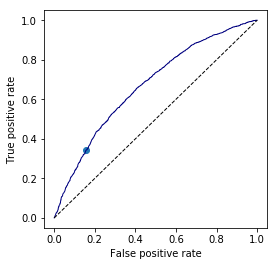

In [120]:
print("1. confusion matrix:\n")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# 2. accuracy 
print("\n2. accuracy:", '%.3f' % accuracy_score(y_test, y_pred))

# 3. ROC curve / ROC point
print("\n4. ROC curve:\n")
tn, fp, fn, tp = cm.ravel()
fpr_pt = fp/(tn+fp)
tpr_pt = tp/(tp+fn)

fpr, tpr, _ = roc_curve(y_test, pred_prob)

plt.subplots(figsize=(4,4))
plt.plot(fpr_pt, tpr_pt,marker='o', label='Logistic Regression')
plt.plot(fpr, tpr, lw=1, color='navy')
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')

plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show();

# Ramdon Forest Classifier
---

In [121]:
from sklearn.ensemble import RandomForestClassifier

In [129]:
clf = RandomForestClassifier(max_depth=5, n_estimators=500, max_features= "sqrt", verbose =2)

In [130]:
clf.fit(X_train, y_train)

building tree 1 of 500
building tree 2 of 500


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500
building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500
building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500

building tree 335 of 500
building tree 336 of 500
building tree 337 of 500
building tree 338 of 500
building tree 339 of 500
building tree 340 of 500
building tree 341 of 500
building tree 342 of 500
building tree 343 of 500
building tree 344 of 500
building tree 345 of 500
building tree 346 of 500
building tree 347 of 500
building tree 348 of 500
building tree 349 of 500
building tree 350 of 500
building tree 351 of 500
building tree 352 of 500
building tree 353 of 500
building tree 354 of 500
building tree 355 of 500
building tree 356 of 500
building tree 357 of 500
building tree 358 of 500
building tree 359 of 500
building tree 360 of 500
building tree 361 of 500
building tree 362 of 500
building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.0min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=2,
            warm_start=False)

In [131]:
y_pred = clf.predict(X_test)
pred_prob = clf.predict_proba(X_test)[:,1]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    0.1s finished


1. confusion matrix:

[[4461    0]
 [2903    0]]

2. accuracy: 0.606

4. ROC curve:



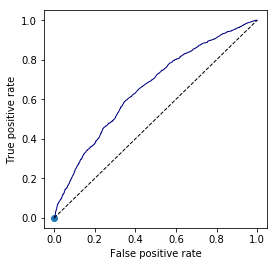

In [132]:
print("1. confusion matrix:\n")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# 2. accuracy 
print("\n2. accuracy:", '%.3f' % accuracy_score(y_test, y_pred))

# 3. ROC curve / ROC point
print("\n4. ROC curve:\n")
tn, fp, fn, tp = cm.ravel()
fpr_pt = fp/(tn+fp)
tpr_pt = tp/(tp+fn)

fpr, tpr, _ = roc_curve(y_test, pred_prob)

plt.subplots(figsize=(4,4))
plt.plot(fpr_pt, tpr_pt,marker='o', label='Logistic Regression')
plt.plot(fpr, tpr, lw=1, color='navy')
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')

plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.show();

* Strange, RF at 0.5 threshold predicts all for non-delays
* RF has a bias in this setup. Because of so many categorical variables for `Departure_Airport`, it will pick too often it and put too much importance toward departure airport.
